## 1. diff metric

## function

In [1]:
import math
import sys
sys.path.append("../../CodeSum")
sys.path.append("../../CodeSum/util")
import torch
from util.Config import Config as cf
from util.DataUtil import read_pickle_data, read_funcom_format_data, make_directory,write_to_pickle
from util.EvaluateUtil import calculate_bleu,calculate_bleu_uml,compute_predictions_uml,calc_all_metrics, metetor_rouge_cider
from util.GPUUtil import set_device, move_model_to_device
from runGruUml import read_uml_format_data

/home/yanlwang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.path.append("/datadrive/CodeSum/util/meteor/")

In [3]:
# from rouge import Rouge
import sys
sys.path.append("../../CodeSum/util")
from meteor.meteor import Meteor
from util.rouge.rouge import Rouge
from cider.cider import Cider

In [4]:
def load_summary(sum_len, batch_size, ids, col, use_full_sum):
    """"
    col: 'train', 'val', 'test'
    """
    docstring_tokens_split_path = cf.docstring_tokens_split_path
#     docstring_tokens_split_path = "//Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl"
    sum_gt = read_pickle_data(docstring_tokens_split_path)[col]  # summary ground truth of validation set
    new_len = batch_size * (math.floor(len(ids) / batch_size))
    if use_full_sum:
        trgs = [sum_gt[i] for i in ids[: new_len]]   # use full ground truth summary
    else:
        trgs = [sum_gt[i][:sum_len - 1] for i in ids[: new_len]]   # use the first sum_len ground truth summary
    trgs = [[t] for t in trgs]  # a list of lists
    return trgs, ids[: new_len]

In [5]:

def load_model(model_path):
    set_device(-1)
    model = torch.load(model_path, map_location=torch.device('cpu'))
    move_model_to_device(model)
    return model

In [6]:
from util.EvaluateUtil import calculate_bleu,calculate_bleu_uml,compute_predictions_uml,calc_all_metrics,compute_predictions

In [7]:
def predict_result( model_path,output_prediction_path,output_prediction_filename):

    model = load_model(model_path)
    set_device(cf.gpu_id)
    move_model_to_device(model)
    train_dataset, val_dataset, test_dataset, train_data_loader, val_data_loader, test_data_loader, code_vocab_size, \
    sbt_vocab_size, summary_vocab_size, summary_vocab, summary_len, val_ids, test_ids = read_funcom_format_data(cf.in_path)

    cf.use_full_sum = False
    summary_len = len(train_dataset.summary[0])
    # preds = compute_predictions(model, test_data_loader, summary_token_i2w, trimTilEOS=cf.trimTilEOS)
    trgs, test_fids = load_summary(summary_len, cf.batch_size, test_ids, 'test', use_full_sum=cf.use_full_sum)
    # bleu_results = calc_all_metrics(preds=preds, refs=trgs)
    preds =compute_predictions(model, test_data_loader, summary_vocab['i2w'],  cf.trim_til_EOS)
#     preds = compute_predictions_uml(model, test_data_loader, summary_vocab['i2w'],  cf.trim_til_EOS, uml_test)
    d = {" preds": preds, "trgs":trgs, "test_fids":test_fids}
    write_to_pickle(output_prediction_path, d, str(cf.modeltype) +".pkl")
#     write_to_pickle(output_prediction_path, d, output_prediction_filename+".pkl")
    metetor_rouge_cider(trgs, preds)
    print("---use stemming and replacing 'get' with 'return")
    preds_stem, refs_stem = stem_and_replace_predict_target(preds, trgs)
    metetor_rouge_cider(refs_stem , preds_stem)
    return preds,trgs, test_fids

In [8]:
from util.DataUtil import read_pickle_data,stem_and_replace_predict_target

In [9]:
def predict_result_uml( model_path,output_prediction_path,output_prediction_filename):
    model = load_model(model_path)
    set_device(cf.gpu_id)
    move_model_to_device(model)
    train_dataset, val_dataset, test_dataset, train_data_loader, val_data_loader, test_data_loader, code_vocab_size, \
        sbt_vocab_size, summary_vocab_size, summary_vocab, summary_len, val_ids, test_ids, uml_train, uml_val, uml_test = \
        read_uml_format_data(cf.in_path, cf.uml_path)
    summary_len = len(train_dataset.summary[0])
    cf.use_full_sum = False
    trgs, test_fids = load_summary(summary_len, cf.batch_size, test_ids, 'test', use_full_sum=cf.use_full_sum)
    # bleu_results = calc_all_metrics(preds=preds, refs=trgs)
    uml_data = read_pickle_data(cf. uml_path)
#     ret, ba, codeBert_bleu = calculate_bleu_uml(model, test_data_loader, summary_vocab['i2w'], trgs_trunc, cf.trim_til_EOS, uml_test)

    preds = compute_predictions_uml(model, test_data_loader, summary_vocab['i2w'],  cf.trim_til_EOS, uml_test)
    d = {" preds": preds, "trgs":trgs, "test_fids":test_fids}
    write_to_pickle(output_prediction_path, d, str(cf.decoder_type) +".pkl")
#     write_to_pickle(output_prediction_path, d, output_prediction_filename+".pkl")
    metetor_rouge_cider(trgs, preds)
    print("---use stemming and replacing 'get' with 'return")
    preds_stem, refs_stem = stem_and_replace_predict_target(preds,trgs)
    metetor_rouge_cider(refs_stem , preds_stem)
    return preds,trgs, test_fids

In [10]:
import os
import time 

In [12]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.class_only= False
cf.uml_path = "/datadrive/Data/csn/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")

## hybrid DRL

In [75]:
import pickle
# path = "/datadrive/enshi/output_clen12/hybrid_drl/hybrid_result.pkl"
path = "/datadrive/enshi/hybrid_drl/hybrid_result_30epoch.pkl"
DRL_result = pickle.load(open(path, 'rb'))

In [76]:
#def calc_all_metrics(preds, refs):
from util.EvaluateUtil import calc_all_metrics

In [89]:
preds = []
refs = []
for item in DRL_result:
#     if item["fid"] in test_fids_att_gru:
    preds.append(item['pred'])
    refs.append(item['tgt'])

In [78]:
DRL_result[:2]

[{'fid': 469779,
  'pred': ['returns', 'the', 'given', 'value', 'of', 'the', 'queue'],
  'tgt': [['makes', 'sure', 'the', 'fast', 'path', 'emits', 'in', 'order']]},
 {'fid': 469780,
  'pred': ['returns', 'an', 'observable', 'of', 'the', 'given', 'iterable'],
  'tgt': [['mirrors',
    'the',
    'one',
    'observable',
    'source',
    'in',
    'an',
    'iterable',
    'of',
    'several']]}]

In [40]:
len(preds)

17280

In [52]:
preds[:2000]

[['creates', 'a'],
 ['creates', 'a', 'new', 'connection', 'with', 'the', 'given', 'number'],
 ['sets', 'the', 'resource', 'at', 'the', 'given', 'index'],
 ['replaces', 'the', 'given', 'resource', 'at', 'the', 'given', 'index'],
 ['create', 'a'],
 ['create', 'a'],
 ['creates', 'a'],
 ['creates', 'a', 'new', 'task', 'with', 'the', 'given'],
 ['creates', 'a', 'new', 'action', 'for', 'the', 'given', 'action'],
 ['creates', 'a', 'new', 'future', 'from', 'the', 'given'],
 ['creates', 'a', 'new', 'future', 'from', 'the', 'given'],
 ['creates', 'a', 'subscription'],
 ['returns', 'a', 'value', 'of', 'the', 'given'],
 ['creates', 'a', 'new', 'instance', 'of', 'the', 'given', 'callable'],
 ['creates', 'a', 'new', 'instance', 'of', 'the', 'given', 'callable'],
 ['creates', 'a', 'new', 'instance', 'of', 'the', 'given', 'callable'],
 ['creates', 'a', 'new'],
 ['creates', 'a', 'new', 'instance', 'of', 'the', 'given', 'create'],
 ['creates', 'a', 'new', 'instance', 'of', 'the'],
 ['creates', 'a', 'new

In [90]:
st = time.perf_counter()
ret ,codeBert_bleu, codeBert_bleu_stem = calc_all_metrics(preds, refs)
print(ret)
print("time cost: ",time.perf_counter() -st)


empty_cnt 6
Cumulative 4-gram BLEU (BLEU-4): 5.71
Cumulative 1/2/3-gram BLEU: 18.32, 11.24, 7.68
Individual 2/3/4-gram BLEU: 6.89, 3.59, 2.34
EMSE BLEU: 11.62
CodeBert Smooth Bleu: 14.142696
Other Smooth Bleu: 20.240000
---use stemming and replacing 'get' with 'return'---- 
Cumulative 4-gram BLEU (BLEU-4): 5.98
Cumulative 1/2/3-gram BLEU: 19.19, 11.91, 8.1
Individual 2/3/4-gram BLEU: 7.39, 3.75, 2.41
EMSE BLEU: 11.92
CodeBert Smooth Bleu: 14.665891
Other Smooth Bleu: 19.650000

time cost:  73.74127679131925


In [86]:
preds = []
refs = []
for item in DRL_result:
    if item["fid"] in test_fids_att_gru:
        preds.append(item['pred'])
        refs.append(item['tgt'])

In [91]:
len(preds)

25380

In [96]:
 for r in refs:
    if len(r[0]) > 10:
        print(r)
        break

In [87]:
st = time.perf_counter()
ret ,codeBert_bleu, codeBert_bleu_stem = calc_all_metrics(preds, refs)
print(ret)
print("time cost: ",time.perf_counter() -st)


empty_cnt 3
Cumulative 4-gram BLEU (BLEU-4): 5.51
Cumulative 1/2/3-gram BLEU: 16.87, 10.4, 7.25
Individual 2/3/4-gram BLEU: 6.41, 3.53, 2.42
EMSE BLEU: 12.5
CodeBert Smooth Bleu: 14.310341
Other Smooth Bleu: 18.110000
---use stemming and replacing 'get' with 'return'---- 
Cumulative 4-gram BLEU (BLEU-4): 5.78
Cumulative 1/2/3-gram BLEU: 17.68, 11.03, 7.64
Individual 2/3/4-gram BLEU: 6.88, 3.67, 2.49
EMSE BLEU: 12.76
CodeBert Smooth Bleu: 14.760000
Other Smooth Bleu: 17.510000

time cost:  51.09652685932815


In [81]:
preds[:3]

[['returns', 'the', 'given', 'value', 'of', 'the', 'queue'],
 ['returns', 'an', 'observable', 'of', 'the', 'given', 'iterable'],
 ['returns', 'an', 'observable', 'of', 'the', 'given', 'iterable']]

In [82]:
refs[:3]

[[[['makes', 'sure', 'the', 'fast', 'path', 'emits', 'in', 'order']]],
 [[['mirrors',
    'the',
    'one',
    'observable',
    'source',
    'in',
    'an',
    'iterable',
    'of',
    'several']]],
 [[['mirrors',
    'the',
    'one',
    'observable',
    'source',
    'in',
    'an',
    'array',
    'of',
    'several']]]]

In [84]:
st = time.perf_counter()
preds_stem, refs_stem = stem_and_replace_predict_target(preds,refs)
metetor_rouge_cider(refs_stem , preds_stem)
print("time cost: ",time.perf_counter() -st)

empty_cnt 6
Meteor:  0.08859706549291856
ROUGe:  0.2233406437206399
Cider:  0.6874137469115656
time cost:  23.514113636687398


In [28]:
len(test_fids_att_gru)

17152

In [20]:
DRL_result[:2]

[{'fid': 469779,
  'pred': 'creates a',
  'tgt': 'makes sure the fast path emits in order'},
 {'fid': 470062,
  'pred': 'creates a new connection with the given number',
  'tgt': 'returns an observable that automatically connects at most once to this'}]

In [46]:
import pickle
path = "/datadrive/enshi/output_clen12/hybrid_drl/hybrid_result.pkl"
DRL_result = pickle.load(open(path, 'rb'))

In [53]:
preds = []
refs = []
for item in DRL_result:
#     if item["fid"] in test_fids_att_gru:
    preds.append(item['pred'])
    refs.append([item['tgt']])

In [54]:
st = time.perf_counter()
ret ,codeBert_bleu, codeBert_bleu_stem = calc_all_metrics(preds, refs)
print(ret)
print("time cost: ",time.perf_counter() -st)


empty_cnt 5


ZeroDivisionError: Fraction(0, 0)

In [49]:
st = time.perf_counter()
preds_stem, refs_stem = stem_and_replace_predict_target(preds,refs)
metetor_rouge_cider(refs_stem , preds_stem)
print("time cost: ",time.perf_counter() -st)

empty_cnt 5
Meteor:  0.0690132024136215
ROUGe:  0.19472662190931095
Cider:  0.4019928813112584
time cost:  16.989781036973


## 1.1 ASTAttGRU_AttTwoChannel

In [59]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.modeltype = 'uml'
cf.class_only= False
cf.gnn_type= "GCN"
cf.decoder_type = "ASTAttGRU_AttTwoChannel"
cf.uml_path = "/datadrive/Data/csn/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")
root = "/datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_AttTwoChannel/"
model_file = "11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannel20200418161942.pt"
# model_file  ="11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_UML20200418084336.pt"

output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )

In [33]:
from util.DataUtil import read_pickle_data, read_funcom_format_data, make_directory,write_to_pickle

In [60]:
st = time.perf_counter()
preds_ASTAttGRU_AttTwoChannel,trgs_ASTAttGRU_AttTwoChannel, test_fids_ASTAttGRU_AttTwoChannel = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_AttTwoChannel/predict/ASTAttGRU_AttTwoChannel.pkl
Meteor:  0.14090999685297775
ROUGe:  0.30487096440588185
Cider:  1.1215672286586262
---use stemming and replacing 'get' with 'return
empty_cnt 110
Meteor:  0.1496921904788668
ROUGe:  0.3267032887111837
Cider:  1.2006155939942138
time cost:  127.63588539883494


In [38]:
st = time.perf_counter()
metetor_rouge_cider(trgs_uml, preds_uml)
print("time cost: ",time.perf_counter() -st)

Meteor:  0.14090999685297775
ROUGe:  0.30487096440588185
Cider:  1.1215672286586262
time cost:  22.774403074756265


In [ ]:
###

## 1.2 ASTAttGRU_Gate

In [42]:
cf.decoder_type = "ASTAttGRU_Gate"
root = "/datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_GRU_Gate"
# model_file = "11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannel20200418161942.pt"
model_file = "28dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_Gate20200419013555.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )

In [43]:
st = time.perf_counter()
preds_ASTAttGRU_Gate,trgs_ASTAttGRU_Gate, test_fids_ASTAttGRU_Gate = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_GRU_Gate/predict/ASTAttGRU_Gate.pkl
Meteor:  0.1404932727316636
ROUGe:  0.3045827530139822
Cider:  1.1286272752530722
time cost:  106.74220715276897


In [61]:
print("---use stemming and replacing 'get' with 'return")
preds_stem, refs_stem = stem_and_replace_predict_target(preds_ASTAttGRU_Gate,trgs_ASTAttGRU_Gate)
metetor_rouge_cider(refs_stem , preds_stem)

---use stemming and replacing 'get' with 'return
empty_cnt 27
Meteor:  0.14828829701182744
ROUGe:  0.3249642796280916
Cider:  1.2039459477011487


## 1.3 ASTAttGRU_UML

In [36]:
cf.decoder_type = "ASTAttGRU_UML"
root = "/datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_UML"
# model_file = "11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannel20200418161942.pt"
model_file  ="11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_UML20200418084336.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )

In [37]:
st = time.perf_counter()
preds_ASTAttGRU_UML,trgs_ASTAttGRU_UML, test_fids_ASTAttGRU_UML = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_UML/predict/ASTAttGRU_UML.pkl
Meteor:  0.13994062587151482
ROUGe:  0.30303525406402265
Cider:  1.1117593610059082
time cost:  163.48795099928975


In [62]:
print("---use stemming and replacing 'get' with 'return")
preds_stem, refs_stem = stem_and_replace_predict_target(preds_ASTAttGRU_UML,trgs_ASTAttGRU_UML)
metetor_rouge_cider(refs_stem , preds_stem)

---use stemming and replacing 'get' with 'return
empty_cnt 100
Meteor:  0.14806414677900345
ROUGe:  0.32368423296205256
Cider:  1.1885295944457455


## 1.4  ASTAttGRU_AttTwoChannelTrans

In [39]:
cf.decoder_type = "ASTAttGRU_AttTwoChannelTrans"
root = "/datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_AttTwoChannelTrans"
# model_file = "11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannel20200418161942.pt"
model_file = "17dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200418155507.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_AttTwoChannelTrans,trgs_AttTwoChannelTrans, test_fids_AttTwoChannelTrans = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_AttTwoChannelTrans/predict/ASTAttGRU_AttTwoChannelTrans.pkl
Meteor:  0.1396377620441544
ROUGe:  0.3001220703923665
Cider:  1.1141232615123846
time cost:  167.4581704288721


In [63]:
print("---use stemming and replacing 'get' with 'return")
preds_stem, refs_stem = stem_and_replace_predict_target(preds_AttTwoChannelTrans,trgs_AttTwoChannelTrans)
metetor_rouge_cider(refs_stem , preds_stem)

---use stemming and replacing 'get' with 'return
empty_cnt 110
Meteor:  0.14829682124405383
ROUGe:  0.32244317002062967
Cider:  1.1943105463036745


## 1.5 ASTAttGRU_BertAtt  

In [41]:
cf.decoder_type = "ASTAttGRU_BertAtt"
root = "/datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_BertAtt"
# model_file = "11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannel20200418161942.pt"
model_file = "28dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200418084144.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_BertAtt,trgs_BertAtt, test_fids_BertAtt = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_BertAtt/predict/ASTAttGRU_BertAtt.pkl
Meteor:  0.12271930810530078
ROUGe:  0.27556332735473915
Cider:  0.8803039330145874
time cost:  96.70042876154184


In [64]:
print("---use stemming and replacing 'get' with 'return")
preds_stem, refs_stem = stem_and_replace_predict_target(preds_BertAtt,trgs_BertAtt)
metetor_rouge_cider(refs_stem , preds_stem)

---use stemming and replacing 'get' with 'return
empty_cnt 3
Meteor:  0.12908668247809454
ROUGe:  0.29248908692892006
Cider:  0.9362825295297346


## 1.6 ast-att-gru

In [13]:
cf.modeltype = "ast-att-gru"
root = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256"
model_file = "8dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtast-att-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGAT_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200418112103.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_ast_att_gru,trgs_ast_att_gru, test_fids_ast_att_gru = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/ast-att-gru.pkl
Meteor:  0.12292547005220746
ROUGe:  0.2752257328018359
Cider:  0.8986788889452594
---use stemming and replacing 'get' with 'return
empty_cnt 18
Meteor:  0.12966786837206787
ROUGe:  0.2933443757320539
Cider:  0.956598927730819
time cost:  97.18633691035211


## 1.7 att-gru

In [14]:
cf.modeltype = "att-gru"
root = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256"
model_file = "16dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtatt-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGAT_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200418145530.pt"

output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_att_gru,trgs_att_gru, test_fids_att_gru = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/att-gru.pkl
Meteor:  0.11862061916598536
ROUGe:  0.266382625395865
Cider:  0.8279405493728816
---use stemming and replacing 'get' with 'return
empty_cnt 19
Meteor:  0.12493924179034917
ROUGe:  0.2831848594190019
Cider:  0.876954154723811
time cost:  60.367088567465544


In [51]:
preds_att_gru[:2]

[['call', 'the', 'validator', 'for', 'comparing', 'ops', 'ops'],
 ['the',
  'method',
  'initiates',
  'the',
  'calculation',
  'of',
  'the',
  'calculation']]

In [25]:
test_fids_att_gru

[469779,
 470062,
 470109,
 470110,
 470111,
 470112,
 470113,
 470116,
 470117,
 470118,
 470119,
 470120,
 470121,
 470122,
 470123,
 470124,
 470125,
 470126,
 470127,
 470128,
 470129,
 470130,
 470131,
 470132,
 470133,
 470134,
 470135,
 470136,
 470137,
 470138,
 470139,
 470140,
 470141,
 470142,
 470143,
 470144,
 470145,
 470146,
 470147,
 470148,
 470149,
 470150,
 470151,
 470152,
 470153,
 470154,
 470155,
 470156,
 470157,
 470158,
 470159,
 470160,
 470161,
 470162,
 470163,
 470164,
 470165,
 470166,
 470167,
 470168,
 470170,
 470171,
 470172,
 470173,
 470256,
 470257,
 470258,
 470259,
 470260,
 470261,
 470262,
 470263,
 470264,
 470265,
 470266,
 470268,
 470269,
 470270,
 470271,
 470272,
 470273,
 470277,
 470278,
 470279,
 470280,
 470281,
 470283,
 470284,
 470287,
 470288,
 470289,
 470290,
 470291,
 470292,
 470293,
 470294,
 470295,
 470296,
 470297,
 470298,
 470299,
 470301,
 470302,
 470303,
 470308,
 470309,
 470310,
 470311,
 470315,
 470316,
 470317,
 

##  1.8 deepcom
5dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mth-deepcom_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGAT_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200418060136.pt

In [57]:
cf.modeltype = "h-deepcom"
root = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256"
model_file = "5dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mth-deepcom_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGAT_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200418060136.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_deepcom,trgs_deepcom, test_fids_deepcom = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/h-deepcom.pkl
Meteor:  0.0914107915291102
ROUGe:  0.2295261407988264
Cider:  0.5148695351473963
---use stemming and replacing 'get' with 'return
empty_cnt 13
Meteor:  0.09813000697024188
ROUGe:  0.24830103075824692
Cider:  0.5638205991567646
time cost:  241.3480626028031


## 1.9 codenn

In [58]:
cf.modeltype = "codenn"
root = "/datadrive/enshi/output_clen12/output_diff_modeltype_hdim256"
model_file = "23dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtcodenn_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGAT_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200418162759.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_codenn,trgs_codenn, test_fids_codenn = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_modeltype_hdim256/predict/codenn.pkl
Meteor:  0.07693915867555615
ROUGe:  0.19542626374260516
Cider:  0.41523989655271776
---use stemming and replacing 'get' with 'return
empty_cnt 0
Meteor:  0.07992681672913704
ROUGe:  0.20423974175376744
Cider:  0.44366553375926365
time cost:  229.75996582396328


# 1.10 ASTAttGRU_BertAstAtt

In [66]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.modeltype = 'uml'
cf.class_only= False
cf.gnn_type= "GCN"
cf.decoder_type = "ASTAttGRU_BertAstAtt"
cf.uml_path = "/datadrive/Data/csn/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")
root = "/datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_ASTAttGRU_BertAstAtt/"
# model_file = "11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannel20200418161942.pt"
# model_file  ="11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_UML20200418084336.pt"
model_file = "38dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_BertAstAtt20200419123311.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_ASTAttGRU_BertAstAtt,trgs_ASTAttGRU_BertAstAtt, test_fids_ASTAttGRU_BertAstAtt = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_ASTAttGRU_BertAstAtt/predict/ASTAttGRU_BertAstAtt.pkl
Meteor:  0.13852861371756955
ROUGe:  0.30200700621582016
Cider:  1.12985577872333
---use stemming and replacing 'get' with 'return
empty_cnt 89
Meteor:  0.14695441111936286
ROUGe:  0.32319683508343044
Cider:  1.20680962468293
time cost:  116.69458197243512


# 1.11 ASTAttGRU_Bert_in_paper

In [104]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.modeltype = 'uml'
cf.class_only= False
cf.gnn_type= "GCN"
cf.decoder_type = "ASTAttGRU_BertAtt"
cf.uml_path = "/datadrive/Data/csn/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")
root = "/datadrive/enshi/output_clen12/diff_bert/output_diff_decoder_BertAtt_case3/"

model_file= "28dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.7_0.7_0.7-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh128_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200420072819.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_Bert_in_paper,trgs_Bert_in_paper, test_fids_Bert_in_paper = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/diff_bert/output_diff_decoder_BertAtt_case3/predict/ASTAttGRU_BertAtt.pkl
Meteor:  0.12286267294256978
ROUGe:  0.27815536685159087
Cider:  0.8989461895713582
---use stemming and replacing 'get' with 'return
empty_cnt 69
Meteor:  0.13035045026410835
ROUGe:  0.29759370260901485
Cider:  0.9623709132244722
time cost:  121.18015137501061


## 1.12  ASTAttGRU_AttTwoChannelTrans_in_paper

In [106]:
cf.gnn_type= "HGCN"
cf.decoder_type = "ASTAttGRU_AttTwoChannelTrans"

root = "/datadrive/enshi/output_clen12/diff_parameter_HGCN/output_HGCN_meandp07hdim/"
model_file="30dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.5_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200420180010.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_Trans_in_paper,trgs_Trans_in_paper, test_fids_Trans_in_paper = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/diff_parameter_HGCN/output_HGCN_meandp07hdim/predict/ASTAttGRU_AttTwoChannelTrans.pkl
Meteor:  0.13836967551972476
ROUGe:  0.302352369481544
Cider:  1.1185699999704535
---use stemming and replacing 'get' with 'return
empty_cnt 124
Meteor:  0.14699036970001694
ROUGe:  0.3241926125292529
Cider:  1.2015768477549553
time cost:  154.6204387228936


## 1.12.1 ASTAttGRU_AttTwoChannelTrans_in_paper clen=64

In [109]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.modeltype = 'uml'
cf.class_only= False
cf.gnn_type= "HGCN"
cf.decoder_type = "ASTAttGRU_AttTwoChannelTrans"
cf.uml_path = "/datadrive/Data/csn/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen64_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")
root = "/datadrive/enshi/output_clen12/diff_bert/output_diff_decoder_BertAtt_case3/"

model_file= "28dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.7_0.7_0.7-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh128_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200420072819.pt"
output_prediction_file = model_file + 'clen64.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_clen64,trgs_clen64, test_fids_clen64 = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)
st = time.perf_counter()
ret ,codeBert_bleu, codeBert_bleu_stem = calc_all_metrics(preds_clen64,trgs_clen64)
print(ret)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/diff_bert/output_diff_decoder_BertAtt_case3/predict/ASTAttGRU_AttTwoChannelTrans.pkl
Meteor:  0.08057926665807093
ROUGe:  0.24613623342127214
Cider:  0.6526233336924863
---use stemming and replacing 'get' with 'return
empty_cnt 69
Meteor:  0.08494329234890693
ROUGe:  0.2622858303640203
Cider:  0.7016151689786225
time cost:  190.1313183773309
empty_cnt 69
Cumulative 4-gram BLEU (BLEU-4): 3.34
Cumulative 1/2/3-gram BLEU: 13.85, 7.87, 4.89
Individual 2/3/4-gram BLEU: 4.47, 1.89, 1.07
EMSE BLEU: 14.69
CodeBert Smooth Bleu: 13.046906
Other Smooth Bleu: 16.200000
---use stemming and replacing 'get' with 'return'---- 
Cumulative 4-gram BLEU (BLEU-4): 3.57
Cumulative 1/2/3-gram BLEU: 14.67, 8.41, 5.22
Individual 2/3/4-gram BLEU: 4.82, 2.02, 1.14
EMSE BLEU: 15.11
CodeBert Smooth Bleu: 13.511247
Other Smooth Bleu: 15.880000

time cost:  78.08826383575797


### 1.12.2 ASTAttGRU_AttTwoChannel in_paper clen=64

In [108]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.modeltype = 'uml'
cf.class_only= False
cf.gnn_type= "GCN"
cf.decoder_type = "ASTAttGRU_AttTwoChannel"
cf.uml_path = "/datadrive/Data/csn/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen64_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")
root = "/datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_AttTwoChannel/"
model_file = "11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannel20200418161942.pt"
# model_file  ="11dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl_mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_UML20200418084336.pt"
output_prediction_file = model_file + 'AttTwoChannelclen64.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
preds_AttTwoChannelclen64,trgs_AttTwoChannelclen64, test_fids_AttTwoChannelclen64 = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)
st = time.perf_counter()
ret ,codeBert_bleu, codeBert_bleu_stem = calc_all_metrics(preds_AttTwoChannelclen64,trgs_AttTwoChannelclen64)
print(ret)
print("time cost: ",time.perf_counter() -st)


INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/output_diff_decoder/output_diff_decoder_AttTwoChannel/predict/ASTAttGRU_AttTwoChannel.pkl
Meteor:  0.09155716964983728
ROUGe:  0.2703616721515395
Cider:  0.8198182869948443
---use stemming and replacing 'get' with 'return
empty_cnt 50
Meteor:  0.09616081985449461
ROUGe:  0.2878079175753792
Cider:  0.8771148069709921
time cost:  202.30260941013694
empty_cnt 50
Cumulative 4-gram BLEU (BLEU-4): 3.91
Cumulative 1/2/3-gram BLEU: 14.7, 8.81, 5.66
Individual 2/3/4-gram BLEU: 5.28, 2.34, 1.28
EMSE BLEU: 15.39
CodeBert Smooth Bleu: 14.217582
Other Smooth Bleu: 17.230000
---use stemming and replacing 'get' with 'return'---- 
Cumulative 4-gram BLEU (BLEU-4): 4.17
Cumulative 1/2/3-gram BLEU: 15.51, 9.36, 6.03
Individual 2/3/4-gram BLEU: 5.65, 2.5, 1.38
EMSE BLEU: 15.86
CodeBert Smooth Bleu: 14.732007
Other Smooth Bleu: 16.810000

time cost:  77.29018667340279


## 2. save predict result

In [67]:
import pickle
csn = pickle.load(open("/datadrive/Data/csn/csn.pkl","rb"))

In [68]:
summary_all_len = pickle.load(open("/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl","rb"))

In [98]:
import random

In [99]:
def save_result(preds_bert_clen10,trgs_bert_clen10,
               preds_bert_clen12,trgs_bert_clen12,
               preds_bert_clen15,trgs_bert_clen15,
               preds_bert_clen16,trgs_bert_clen16,
               preds_bert_clen21,trgs_bert_clen21,
               preds_bert_clen32,trgs_bert_clen32,test_fids_bert_clen21
               ):
    output_results = []
    
    iteration_list = list(range(len(preds_bert_clen21)))
    random.shuffle(iteration_list )
    error_bar =1
    for i in iteration_list :
        predict = set(preds_bert_clen10[i])
        target = set(trgs_bert_clen10[i][0])
        clen10 = len (predict -  target ) <  error_bar and  len (target - predict) <  error_bar

        predict = set(preds_bert_clen12[i])
        target = set(trgs_bert_clen12[i][0])
        clen12 = len (predict -  target ) <  error_bar and  len (target - predict) <  error_bar

        predict = set(preds_bert_clen15[i])
        target = set(trgs_bert_clen15[i][0])
        clen15 = len (predict -  target ) <  error_bar and  len (target - predict) <  error_bar

        predict = set(preds_bert_clen16[i])
        target = set(trgs_bert_clen16[i][0])
        clen16 = len (predict -  target ) <  error_bar and  len (target - predict) <  error_bar

        predict = set(preds_bert_clen21[i])
        target = set(trgs_bert_clen21[i][0])
        clen21 = len (predict -  target ) <  error_barand  len (target - predict) <  error_bar

        predict = set(preds_bert_clen32[i])
        target = set(trgs_bert_clen32[i][0])
        clen32 = len (predict -  target ) <  error_bar and  len (target - predict) <  error_bar

    



        if clen10 or clen12 or clen15 or clen16 or clen21 or clen32:   
            fid = test_fids_bert_clen21[i]
            name = csn["test"][fid]["func_name"].split(".")

            output_results.append("fid: "+str(fid ))
            output_results.append("class name: "+name[0])
            output_results.append("method name: "+name[-1])
            output_results.append("target: "+" ".join(summary_all_len["test"][fid]))
            output_results.append("ASTAttGRU_BertAstAtt: "+" ".join(preds_bert_clen10[i]))
            output_results.append("ASTAttGRU_AttTwoChannel: "+" ".join(preds_bert_clen12[i]))
            output_results.append("ASTAttGRU_Gate: "+" ".join(preds_bert_clen15[i]))
            output_results.append("ASTAttGRU_UML : "+" ".join(preds_bert_clen16[i]))
            output_results.append("AttTwoChannelTrans: "+" ".join(preds_bert_clen21[i]))
            output_results.append("BertAtt,trgs_BertAtt: "+" ".join(preds_bert_clen32[i]))
            output_results.append("---------------------------------------")
            continue

    with open("./predict/predict_of_diff_decoder(good_case).txt", "w") as output:
        for line in output_results:
            output.write(line + "\r")

In [412]:
def save_all_result(preds_bert_clen10,trgs_bert_clen10,
               preds_bert_clen12,trgs_bert_clen12,
               preds_bert_clen15,trgs_bert_clen15,
               preds_bert_clen16,trgs_bert_clen16,
               preds_bert_clen21,trgs_bert_clen21,
               preds_bert_clen32,trgs_bert_clen32,test_fids_bert_clen21
               ):
    output_results = []
    
    iteration_list = list(range(len(preds_bert_clen21)))
    random.shuffle(iteration_list )
    error_bar =1
    for i in iteration_list :
        predict = set(preds_bert_clen10[i])
        target = set(trgs_bert_clen10[i][0])
        clen10 = len (predict -  target ) <  error_bar and  len (target - predict) <  error_bar
 
        if clen10:
            fid = test_fids_bert_clen21[i]
            name = csn["test"][fid]["func_name"].split(".")

            output_results.append("fid: "+str(fid ))
            output_results.append("class name: "+name[0])
            output_results.append("method name: "+name[-1])
            output_results.append("target: "+" ".join(summary_all_len["test"][fid]))
            output_results.append("UmlCodeSum: "+" ".join(preds_bert_clen10[i]))
            output_results.append("Bert-attn: "+" ".join(preds_bert_clen12[i]))
            output_results.append("ast-attendgru "+" ".join(preds_bert_clen15[i]))
            output_results.append("attengru: "+" ".join(preds_bert_clen16[i]))
            output_results.append("h-deepcom: "+" ".join(preds_bert_clen21[i]))
            output_results.append("codenn: "+" ".join(preds_bert_clen32[i]))
            output_results.append("---------------------------------------")
            continue

    with open("./predict/predict_all_model(good_case).txt", "w") as output:
        for line in output_results:
            output.write(line + "\r")

In [413]:
save_all_result(preds_Trans_in_paper,trgs_Trans_in_paper,
preds_Bert_in_paper,trgs_Bert_in_paper,
preds_ast_att_gru,trgs_ast_att_gru, 
preds_att_gru,trgs_att_gru,
preds_deepcom,trgs_deepcom,
preds_codenn,trgs_codenn, test_fids_codenn)

In [100]:
save_result(preds_ASTAttGRU_BertAstAtt,trgs_ASTAttGRU_BertAstAtt,
preds_ASTAttGRU_AttTwoChannel ,trgs_ASTAttGRU_AttTwoChannel,
preds_ASTAttGRU_Gate,trgs_ASTAttGRU_Gate,
preds_ASTAttGRU_UML ,trgs_ASTAttGRU_UML,
preds_AttTwoChannelTrans,trgs_AttTwoChannelTrans,
preds_BertAtt,trgs_BertAtt,test_fids_BertAtt)

In [102]:
def save_result_with_code(preds_bert_clen10,trgs_bert_clen10,
               preds_bert_clen12,trgs_bert_clen12,
               preds_bert_clen15,trgs_bert_clen15,
               preds_bert_clen16,trgs_bert_clen16,
               preds_bert_clen21,trgs_bert_clen21,
               preds_bert_clen32,trgs_bert_clen32,test_fids_bert_clen21
               ):
    output_results = []
    
    iteration_list = list(range(len(preds_bert_clen21)))
    random.shuffle(iteration_list )
    for i in iteration_list :
        predict = set(preds_bert_clen10[i])
        target = set(trgs_bert_clen10[i][0])
        clen10 = len (predict -  target ) < 2 and  len (target - predict) < 2

        predict = set(preds_bert_clen12[i])
        target = set(trgs_bert_clen12[i][0])
        clen12 = len (predict -  target ) < 2 and  len (target - predict) < 2

        predict = set(preds_bert_clen15[i])
        target = set(trgs_bert_clen15[i][0])
        clen15 = len (predict -  target ) < 2 and  len (target - predict) < 2

        predict = set(preds_bert_clen16[i])
        target = set(trgs_bert_clen16[i][0])
        clen16 = len (predict -  target ) < 2 and  len (target - predict) < 2

        predict = set(preds_bert_clen21[i])
        target = set(trgs_bert_clen21[i][0])
        clen21 = len (predict -  target ) < 2 and  len (target - predict) < 2

        predict = set(preds_bert_clen32[i])
        target = set(trgs_bert_clen32[i][0])
        clen32 = len (predict -  target ) < 2 and  len (target - predict) < 2

        if clen10 or clen12 or clen15 or clen16 or clen21 or clen32:   
            fid = test_fids_bert_clen21[i]
            name = csn["test"][fid]["func_name"].split(".")
            code = csn["test"][fid]["code"]
            output_results.append("fid: "+str(fid ))
            output_results.append("class name: "+name[0])
            output_results.append("method name: "+name[-1])
            output_results.append("target: "+" ".join(summary_all_len["test"][fid]))
            output_results.append("ASTAttGRU_BertAstAtt: "+" ".join(preds_bert_clen10[i]))
            output_results.append("ASTAttGRU_AttTwoChannel: "+" ".join(preds_bert_clen12[i]))
            output_results.append("ASTAttGRU_Gate: "+" ".join(preds_bert_clen15[i]))
            output_results.append("ASTAttGRU_UML : "+" ".join(preds_bert_clen16[i]))
            output_results.append("AttTwoChannelTrans: "+" ".join(preds_bert_clen21[i]))
            output_results.append("BertAtt,trgs_BertAtt: "+" ".join(preds_bert_clen32[i]))
            output_results.append("code \n " +code)
            output_results.append("---------------------------------------")
            continue

    with open("./predict/predict_of_diff_decoder_with_code(good_case).txt", "w") as output:
        for line in output_results:
            output.write(line + "\r")

In [415]:
def save_all_result_with_code(preds_bert_clen10,trgs_bert_clen10,
               preds_bert_clen12,trgs_bert_clen12,
               preds_bert_clen15,trgs_bert_clen15,
               preds_bert_clen16,trgs_bert_clen16,
               preds_bert_clen21,trgs_bert_clen21,
               preds_bert_clen32,trgs_bert_clen32,test_fids_bert_clen21
               ):
    output_results = []
    
    iteration_list = list(range(len(preds_bert_clen21)))
    random.shuffle(iteration_list )
    for i in iteration_list :
        predict = set(preds_bert_clen10[i])
        target = set(trgs_bert_clen10[i][0])
        clen10 = len (predict -  target ) < 1 and  len (target - predict) < 1

        if clen10:   
            fid = test_fids_bert_clen21[i]
            name = csn["test"][fid]["func_name"].split(".")
            code = csn["test"][fid]["code"]
            output_results.append("fid: "+str(fid ))
            output_results.append("class name: "+name[0])
            output_results.append("method name: "+name[-1])
            output_results.append("target: "+" ".join(summary_all_len["test"][fid]))
            output_results.append("ASTAttGRU_BertAstAtt: "+" ".join(preds_bert_clen10[i]))
            output_results.append("ASTAttGRU_AttTwoChannel: "+" ".join(preds_bert_clen12[i]))
            output_results.append("ASTAttGRU_Gate: "+" ".join(preds_bert_clen15[i]))
            output_results.append("ASTAttGRU_UML : "+" ".join(preds_bert_clen16[i]))
            output_results.append("AttTwoChannelTrans: "+" ".join(preds_bert_clen21[i]))
            output_results.append("BertAtt,trgs_BertAtt: "+" ".join(preds_bert_clen32[i]))
            output_results.append("code \n " +code)
#             output_results.append("code \n " +code)
            output_results.append("---------------------------------------")
            continue

    with open("./predict/predict_all_model_with_code(good_case).txt", "w") as output:
        for line in output_results:
            output.write(line + "\r")

In [419]:
def save_all_result_with_code(preds_bert_clen10,trgs_bert_clen10,
               preds_bert_clen12,trgs_bert_clen12,
               preds_bert_clen15,trgs_bert_clen15,
               preds_bert_clen16,trgs_bert_clen16,
               preds_bert_clen21,trgs_bert_clen21,
               preds_bert_clen32,trgs_bert_clen32,test_fids_bert_clen21
               ):
    output_results = []
    
    iteration_list = list(range(len(preds_bert_clen21)))
    random.shuffle(iteration_list )
    error_bar =1
    for i in iteration_list :
        predict = set(preds_bert_clen10[i])
        target = set(trgs_bert_clen10[i][0])
        clen10 = len (predict -  target ) <  error_bar and  len (target - predict) <  error_bar
 
        if clen10:
            fid = test_fids_bert_clen21[i]
            name = csn["test"][fid]["func_name"].split(".")
            code = csn["test"][fid]["code"]
            output_results.append("fid: "+str(fid ))
            output_results.append("class name: "+name[0])
            output_results.append("method name: "+name[-1])
            output_results.append("target: "+" ".join(summary_all_len["test"][fid]))
            output_results.append("UmlCodeSum: "+" ".join(preds_bert_clen10[i]))
            output_results.append("Bert-attn: "+" ".join(preds_bert_clen12[i]))
            output_results.append("ast-attendgru "+" ".join(preds_bert_clen15[i]))
            output_results.append("attengru: "+" ".join(preds_bert_clen16[i]))
            output_results.append("h-deepcom: "+" ".join(preds_bert_clen21[i]))
            output_results.append("codenn: "+" ".join(preds_bert_clen32[i]))
            output_results.append("code \n " +code)
            output_results.append("---------------------------------------")
            
            continue

    with open("./predict/predict_all_model_with_code(good_case).txt", "w") as output:
        for line in output_results:
            output.write(line + "\r")

In [420]:
save_all_result_with_code(preds_Trans_in_paper,trgs_Trans_in_paper,
preds_Bert_in_paper,trgs_Bert_in_paper,
preds_ast_att_gru,trgs_ast_att_gru, 
preds_att_gru,trgs_att_gru,
preds_deepcom,trgs_deepcom,
preds_codenn,trgs_codenn, test_fids_codenn)

In [103]:
save_result_with_code(preds_ASTAttGRU_BertAstAtt,trgs_ASTAttGRU_BertAstAtt,
preds_ASTAttGRU_AttTwoChannel ,trgs_ASTAttGRU_AttTwoChannel,
preds_ASTAttGRU_Gate,trgs_ASTAttGRU_Gate,
preds_ASTAttGRU_UML ,trgs_ASTAttGRU_UML,
preds_AttTwoChannelTrans,trgs_AttTwoChannelTrans,
preds_BertAtt,trgs_BertAtt,test_fids_BertAtt)

## 3 diff_seq_len

copy from https://github.com/wanyao1992/code_summarization_public/blob/4761cddc728bff4f67ccff3cf153446d06708ec8/evaluation/plot_varlength.py

In [61]:
import pickle

In [60]:
code_tokens = pickle.load(open("/datadrive/Data/csn/code/djl1_dfp0_dsi1_dlc1_dr1.pkl","rb"))

In [62]:
summary_tokens =  pickle.load(open("/datadrive/Data/csn/summary/cfp1_csi1_cfd0_clc1.pkl","rb"))

In [63]:
import sys
sys.path.append("/datadrive/CodeSum/util/")
from util.meteor.meteor import Meteor
from util.rouge.rouge import Rouge
from util.cider.cider import Cider
from util.CustomedBleu.smooth_bleu import smooth_bleu
import numpy as np

In [64]:
refs_dict = {}
preds_dict = {}
for i in range(len(preds_Trans_in_paper)):
    preds_dict[i] = [" ".join(preds_Trans_in_paper[i])]
    refs_dict[i] = [" ".join(trgs_Trans_in_paper[i][0])]
_, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
_, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
_, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

NameError: name 'preds_Trans_in_paper' is not defined

In [110]:
_, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
_, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
_, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

In [130]:
def compute_smooth_bleus(refs_list, preds_list):
    bleus_list = []
    for i in range(len(preds_list)):
        refs = refs_list[i]
        preds = preds_list[i]
        r_str_list = []
        p_str_list = []
        for r, p in zip(refs, preds):
            if len(r[0]) == 0 or len(p) == 0:
                continue

            r_str_list.append([" ".join([str(token_id) for token_id in r[0]])])
            p_str_list.append(" ".join([str(token_id) for token_id in p]))

        bleu_list = smooth_bleu(r_str_list, p_str_list)
        bleus_list.append( bleu_list[0])
    return bleus_list

In [131]:
def compute_smooth_bleu(refs, preds):
   
    r_str_list = []
    p_str_list = []
    for r, p in zip(refs, preds):
        if len(r[0]) == 0 or len(p) == 0:
            continue

        r_str_list.append([" ".join([str(token_id) for token_id in r[0]])])
        p_str_list.append(" ".join([str(token_id) for token_id in p]))

    bleu_list = smooth_bleu(r_str_list, p_str_list)
        
    return bleu_list[0]

In [66]:

def calculate_four_metric(code_tokens, preds_in_paper, trgs_in_paper, test_fids_in_paper):
    st = time.perf_counter()
    refs_dict = {}
    preds_dict = {}
    for i in range(len(preds_in_paper)):
        preds_dict[i] = [" ".join(preds_in_paper[i])]
        refs_dict[i] = [" ".join(trgs_in_paper[i][0])]
    _, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
    _, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
    _, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

    step_size = 1
    scores_Meteor_var_codelen = {}
    scores_Rouge_var_codelen = {}
    scores_Cider_var_codelen = {}
    scores_BLEU_var_codelen = {}
    # Bas_code_len ={}
    # codeBerts_code_len ={}
    count_code_len = {}

    for code_len in range(1, 250, step_size):
        scores_Meteor_var_codelen[code_len] = []
        scores_Rouge_var_codelen[code_len] = []
        scores_Cider_var_codelen[code_len] = []
        predict = []
        target = []
        count_code_len[code_len] = 0
        for num in range(len(test_fids_in_paper)):
            fid = test_fids_in_paper[num]
            if len(code_tokens["test"][fid]) == code_len:
                predict.append(preds_in_paper[num])
                target.append(trgs_in_paper[num])
                count_code_len[code_len] += 1
                scores_Meteor_var_codelen[code_len].append(scores_Meteor_Trans[num])
                scores_Rouge_var_codelen[code_len].append(scores_Rouge_Trans[num])
                scores_Cider_var_codelen[code_len].append(scores_Cider_Trans[num])
        if len(predict) == 0:
            continue
        scores_BLEU_var_codelen[code_len] = compute_smooth_bleu(target, predict)

    for i in scores_Meteor_var_codelen:
        scores_Meteor_var_codelen[i] = np.mean(scores_Meteor_var_codelen[i])
        scores_Rouge_var_codelen[i] = np.mean(scores_Rouge_var_codelen[i])
        scores_Cider_var_codelen[i] = np.mean(scores_Cider_var_codelen[i])
    print("time cost: ", time.perf_counter() - st)
    return count_code_len, scores_BLEU_var_codelen,  scores_Meteor_var_codelen, scores_Rouge_var_codelen,scores_Cider_var_codelen

In [235]:
def calculate_four_metric_diff_sum(sum_tokens, preds_in_paper, trgs_in_paper, test_fids_in_paper):
    st = time.perf_counter()
    refs_dict = {}
    preds_dict = {}
    for i in range(len(preds_in_paper)):
        preds_dict[i] = [" ".join(preds_in_paper[i])]
        refs_dict[i] = [" ".join(trgs_in_paper[i][0])]
    _, scores_Meteor_Trans = Meteor().compute_score(refs_dict, preds_dict)
    _, scores_Rouge_Trans = Rouge().compute_score(refs_dict, preds_dict)
    _, scores_Cider_Trans = Cider().compute_score(refs_dict, preds_dict)

    step_size = 1
    scores_Meteor_var_sumlen = {}
    scores_Rouge_var_sumlen = {}
    scores_Cider_var_sumlen = {}
    scores_BLEU_var_sumlen = {}
    # Bas_code_len ={}
    # codeBerts_code_len ={}
    count_sum_len = {}
    # for sum_len in range(30):
    for sum_len in range(1, 31, step_size):
        scores_Meteor_var_sumlen[sum_len] = []
        scores_Rouge_var_sumlen[sum_len] = []
        scores_Cider_var_sumlen[sum_len] = []
        predict = []
        target = []
        count_sum_len[sum_len] = 0
        for num in range(len(test_fids_in_paper)):
            fid = test_fids_in_paper[num]
            if len(sum_tokens["test"][fid]) == sum_len:
                predict.append(preds_in_paper[num])
                target.append(trgs_in_paper[num])
                count_sum_len[sum_len] += 1
                scores_Meteor_var_sumlen[sum_len].append(scores_Meteor_Trans[num])
                scores_Rouge_var_sumlen[sum_len].append(scores_Rouge_Trans[num])
                scores_Cider_var_sumlen[sum_len].append(scores_Cider_Trans[num])
        if len(predict) == 0:
            continue
        scores_BLEU_var_sumlen[sum_len] = compute_smooth_bleu(target, predict)

    for i in scores_Meteor_var_sumlen:
        scores_Meteor_var_sumlen[i] = np.mean(scores_Meteor_var_sumlen[i])
        scores_Rouge_var_sumlen[i] = np.mean(scores_Rouge_var_sumlen[i])
        scores_Cider_var_sumlen[i] = np.mean(scores_Cider_var_sumlen[i])
    print("time cost: ", time.perf_counter() - st)
    return count_sum_len, scores_BLEU_var_sumlen,  scores_Meteor_var_sumlen, scores_Rouge_var_sumlen,scores_Cider_var_sumlen

## UmlCodeSum

In [67]:
count_code_len, scores_BLEU_Trans_var_codelen,  \
scores_Meteor_Trans_var_codelen, scores_Rouge_Trans_var_codelen,\
scores_Cider_Trans_var_codelen = calculate_four_metric \
(code_tokens,preds_Trans_in_paper,trgs_Trans_in_paper, test_fids_Trans_in_paper)

NameError: name 'preds_Trans_in_paper' is not defined

In [59]:
count_sum_len, scores_BLEU_UmlCodeSum_var_sumlen,  \
scores_Meteor_UmlCodeSum_var_sumlen, scores_Rouge_UmlCodeSum_var_sumlen,\
scores_Cider_UmlCodeSum_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_Trans_in_paper,trgs_Trans_in_paper, test_fids_Trans_in_paper)

NameError: name 'calculate_four_metric_diff_sum' is not defined

## bert

In [167]:
count_code_len, scores_BLEU_Bert_var_codelen,  \
scores_Meteor_Bert_var_codelen, scores_Rouge_Bert_var_codelen,\
scores_Cider_Bert_var_codelen = calculate_four_metric \
(code_tokens,preds_Bert_in_paper,trgs_Bert_in_paper, test_fids_Bert_in_paper)

time cost:  26.353545239195228


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [236]:
count_sum_len, scores_BLEU_Bert_var_sumlen,  \
scores_Meteor_Bert_var_sumlen, scores_Rouge_Bert_var_sumlen,\
scores_Cider_Bert_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_Bert_in_paper,trgs_Bert_in_paper, test_fids_Bert_in_paper)

time cost:  21.334305483847857


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## codenn

In [184]:
count_code_len, scores_BLEU_codenn_var_codelen,  \
scores_Meteor_codenn_var_codelen, scores_Rouge_codenn_var_codelen,\
scores_Cider_codenn_var_codelen = calculate_four_metric \
(code_tokens,preds_codenn,trgs_codenn, test_fids_codenn)

time cost:  21.260852813720703


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [237]:
count_sum_len, scores_BLEU_codenn_var_sumlen,  \
scores_Meteor_codenn_var_sumlen, scores_Rouge_codenn_var_sumlen,\
scores_Cider_codenn_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens,preds_codenn,trgs_codenn, test_fids_codenn)

time cost:  24.750988895073533


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## h-deepcom

In [194]:
count_code_len, scores_BLEU_deepcom_var_codelen,  \
scores_Meteor_deepcom_var_codelen, scores_Rouge_deepcom_var_codelen,\
scores_Cider_deepcom_var_codelen = calculate_four_metric \
(code_tokens,preds_deepcom,trgs_deepcom, test_fids_deepcom )

time cost:  20.622683679684997


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [238]:
count_sum_len, scores_BLEU_deepcom_var_sumlen,  \
scores_Meteor_deepcom_var_sumlen, scores_Rouge_deepcom_var_sumlen,\
scores_Cider_deepcom_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_deepcom,trgs_deepcom, test_fids_deepcom )

time cost:  19.962502844631672


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## ast_attendgru

In [196]:
count_code_len, scores_BLEU_ast_attendgru_var_codelen,  \
scores_Meteor_ast_attendgru_var_codelen, scores_Rouge_ast_attendgru_var_codelen,\
scores_Cider_ast_attendgru_var_codelen = calculate_four_metric \
(code_tokens,preds_ast_att_gru,trgs_ast_att_gru, test_fids_ast_att_gru)

time cost:  22.180269865319133


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [239]:
count_sum_len, scores_BLEU_ast_att_gru_var_sumlen,  \
scores_Meteor_ast_att_gru_var_sumlen, scores_Rouge_ast_att_gru_var_sumlen,\
scores_Cider_ast_att_gru_var_sumlen = calculate_four_metric_diff_sum \
(summary_tokens ,preds_ast_att_gru,trgs_ast_att_gru, test_fids_ast_att_gru)

time cost:  21.581020893529058


/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## code

In [274]:
count_code_len

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 1,
 22: 7,
 23: 8,
 24: 19,
 25: 15,
 26: 41,
 27: 44,
 28: 68,
 29: 86,
 30: 95,
 31: 97,
 32: 143,
 33: 138,
 34: 149,
 35: 145,
 36: 152,
 37: 157,
 38: 206,
 39: 173,
 40: 187,
 41: 184,
 42: 166,
 43: 173,
 44: 171,
 45: 174,
 46: 245,
 47: 166,
 48: 195,
 49: 204,
 50: 182,
 51: 173,
 52: 206,
 53: 184,
 54: 188,
 55: 182,
 56: 163,
 57: 214,
 58: 177,
 59: 204,
 60: 146,
 61: 145,
 62: 168,
 63: 145,
 64: 151,
 65: 184,
 66: 154,
 67: 152,
 68: 179,
 69: 117,
 70: 128,
 71: 118,
 72: 178,
 73: 117,
 74: 117,
 75: 124,
 76: 111,
 77: 107,
 78: 114,
 79: 112,
 80: 124,
 81: 102,
 82: 104,
 83: 83,
 84: 146,
 85: 96,
 86: 90,
 87: 118,
 88: 111,
 89: 85,
 90: 122,
 91: 122,
 92: 109,
 93: 75,
 94: 73,
 95: 85,
 96: 78,
 97: 72,
 98: 85,
 99: 62,
 100: 72,
 101: 68,
 102: 89,
 103: 86,
 104: 77,
 105: 73,
 106: 70,
 107: 81,
 108

/home/yanlwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


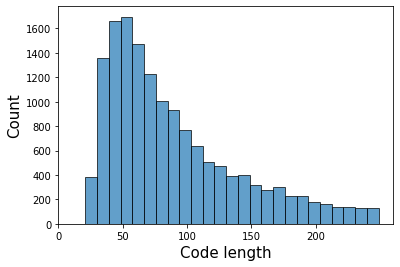

In [317]:
# data = np.random.randn(10000)
# count_code_len
data = []
for code_len in count_code_len:
    data.extend([code_len]*count_code_len[code_len])
fig = plt.figure()
plt.hist(data, bins=25, normed=0, edgecolor="black", alpha=0.7)
plt.xlabel("Code length", fontsize='15')
plt.ylabel("Count",fontsize='15')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(range(0,250,50))
plt.show()
# fig = plt.figure()
fig.savefig('./Figure/diff_code_len.pdf',dpi=600,format='pdf')

In [303]:
len(count_sum_len)

27

/home/yanlwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


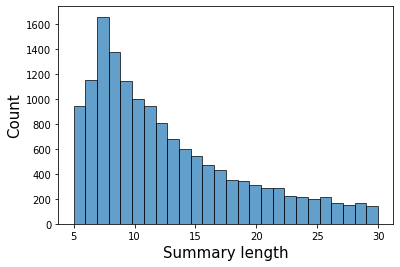

In [318]:
fig = plt.figure()
# fig.savefig('./Figure/diff_summary_len.pdf',dpi=600,format='pdf')
data = []
for code_len in count_sum_len:
    data.extend([code_len]*count_sum_len[code_len])
plt.xlabel("Summary length",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.hist(data, bins=26, normed=0, edgecolor="black", alpha=0.7)
# plt.bar(range(len(count_sum_len)), count_sum_len.values())
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

fig.savefig('./Figure/diff_summary_len.pdf',dpi=600,format='pdf')

In [56]:
def plot_five_bleu(s1_data, s2_data,s3_data,s4_data,s5_data,xlabel,ylabel,step,maxsize,file):
    s1= {}
    s2 = {}
    s3 = {}
    s4 = {}
    s5 = {}
    for i in s1_data:
        if i %step ==0 and i<maxsize:
            s1[i] = s1_data[i]
            s2[i] = s2_data[i]
            s3[i] = s3_data[i]
            s4[i] = s4_data[i]
            s5[i] = s5_data[i]
    fontsize = 15
#     print(s1)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.plot(list(s1.keys()), list(s1.values()), marker='^', linewidth=2.0, markersize=10, label='UmlCodeSum')
    ax.plot(list(s2.keys()), list(s2.values()), marker='*', linewidth=2.0, markersize=10, label='Bert-attn')
    ax.plot(list(s3.keys()), list(s3.values()), marker='o', linewidth=2.0, markersize=10, label='ast_attend_gru')
    ax.plot(list(s4.keys()), list(s4.values()), marker='s', linewidth=2.0, markersize=10, label='h-deppcom')
    ax.plot(list(s5.keys()), list(s5.values()), marker='p', linewidth=2.0, markersize=10, label='codenn')    
    ax.legend(fontsize='10',ncol=1) #, loc='upper center'
    
    my_x_ticks =list(s1.keys())
    plt.xticks(my_x_ticks,fontsize='10')
#     plt.yticks(np.arange(0.150,0.430,0.025))
#     plt.yticks(np.arange(0.06,0.25,0.02),fontsize='10')
#     plt.yticks(np.arange(0.15,0.45,0.05),fontsize='10')
    plt.yticks(fontsize='10')
    plt.show()
    fig.savefig(file)

In [57]:
plot_five_bleu( scores_BLEU_Trans_var_codelen,scores_BLEU_Bert_var_codelen, \
                scores_BLEU_ast_attendgru_var_codelen, scores_BLEU_deepcom_var_codelen,
                 scores_BLEU_codenn_var_codelen, "Code length","BLEU",10,151,'./Figure/varcode_bleu.pdf')

NameError: name 'scores_BLEU_Trans_var_codelen' is not defined

In [ ]:
Meteor Rouge Cider BLEU

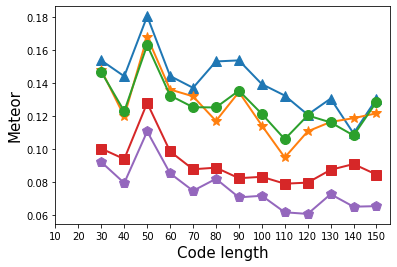

In [371]:
plot_five_bleu( scores_Meteor_Trans_var_codelen,scores_Meteor_Bert_var_codelen, \
                scores_Meteor_ast_attendgru_var_codelen, scores_Meteor_deepcom_var_codelen,
                 scores_Meteor_codenn_var_codelen, "Code length","Meteor",10,151,'./Figure/varcode_meteor.pdf')

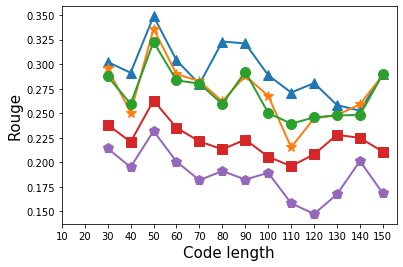

In [372]:
plot_five_bleu( scores_Rouge_Trans_var_codelen,scores_Rouge_Bert_var_codelen, \
                scores_Rouge_ast_attendgru_var_codelen, scores_Rouge_deepcom_var_codelen,
                 scores_Rouge_codenn_var_codelen, "Code length","Rouge",10,151,'./Figure/varcode_rouge.pdf')

In [330]:
np.arange(0.150,0.450,0.025)

array([0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 ,
       0.375, 0.4  , 0.425, 0.45 ])

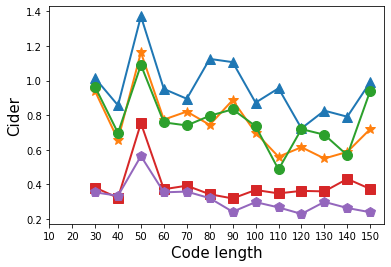

In [373]:
plot_five_bleu( scores_Cider_Trans_var_codelen,scores_Cider_Bert_var_codelen, \
                scores_Cider_ast_attendgru_var_codelen, scores_Cider_deepcom_var_codelen,
                 scores_Cider_codenn_var_codelen, "Code length","Cider",10,151,'./Figure/varcode_cider.pdf')

## summary 

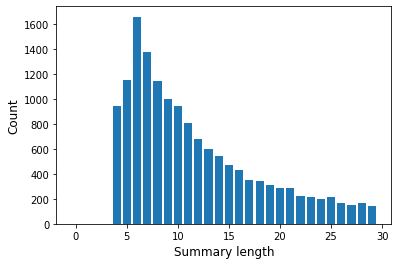

In [270]:
fig = plt.figure()
# fig.savefig('./Figure/diff_summary_len.pdf',dpi=600,format='pdf')
plt.xlabel("Summary length",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.bar(range(len(count_sum_len)), count_sum_len.values())
plt.show()
fig.savefig('./Figure/diff_summary_len.pdf',dpi=600,format='pdf')

/home/yanlwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


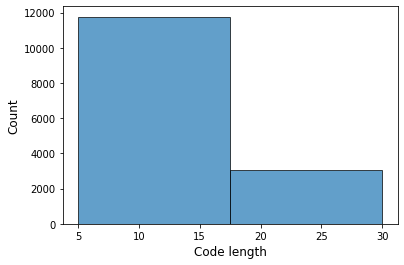

In [266]:

data = []
for code_len in count_sum_len:
    data.extend([code_len]*count_sum_len[code_len])
plt.hist(data, bins=2, normed=0, edgecolor="black", alpha=0.7)
plt.xlabel("Code length", fontsize='12')
plt.ylabel("Count",fontsize='12')
plt.show()

In [ ]:



,
,

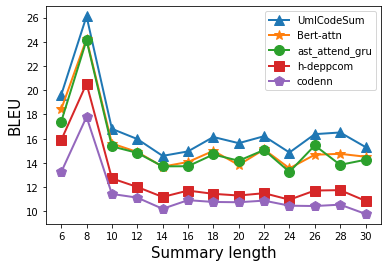

In [396]:
plot_five_bleu( scores_BLEU_UmlCodeSum_var_sumlen,scores_BLEU_Bert_var_sumlen, \
                scores_BLEU_ast_att_gru_var_sumlen, scores_BLEU_deepcom_var_sumlen,
                 scores_BLEU_codenn_var_sumlen, "Summary length","BLEU",2,31, './Figure/varsum_bleu.pdf')

In [ ]:
Meteor Rouge Cider BLEU

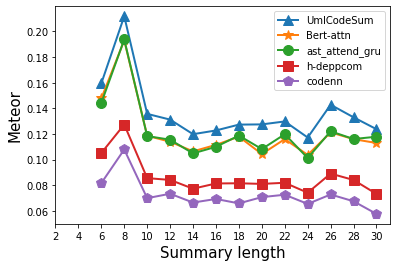

In [392]:
plot_five_bleu( scores_Meteor_UmlCodeSum_var_sumlen,scores_Meteor_Bert_var_sumlen, \
                scores_Meteor_ast_att_gru_var_sumlen, scores_Meteor_deepcom_var_sumlen,
                 scores_Meteor_codenn_var_sumlen, "Summary length","Meteor",2,31,'./Figure/varsum_meteor.pdf')

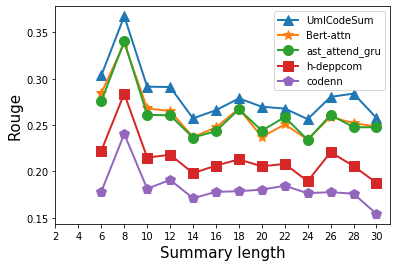

In [393]:
plot_five_bleu( scores_Rouge_UmlCodeSum_var_sumlen,scores_Rouge_Bert_var_sumlen, \
                scores_Rouge_ast_att_gru_var_sumlen, scores_Rouge_deepcom_var_sumlen,
                 scores_Rouge_codenn_var_sumlen, "Summary length","Rouge",2,31,'./Figure/varsum_rouge.pdf')

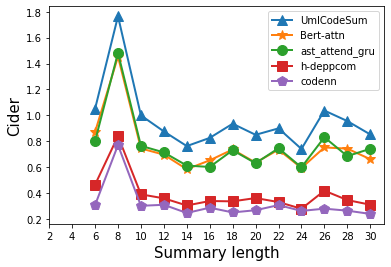

In [394]:
plot_five_bleu( scores_Cider_UmlCodeSum_var_sumlen,scores_Cider_Bert_var_sumlen, \
                scores_Cider_ast_att_gru_var_sumlen, scores_Cider_deepcom_var_sumlen,
                 scores_Cider_codenn_var_sumlen, "Summary length","Cider",2,31,'./Figure/varsum_cider.pdf')

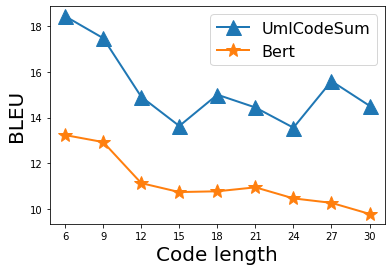

In [395]:
 plot_two_bleu( scores_BLEU_Bert_var_sumlen, scores_BLEU_codenn_var_sumlen,"Code length","BLEU",3)

In [191]:
def plot_three_bleu(s1_data, s2_data,s3_data,xlabel,ylabel,step):
    s1= {}
    s2 = {}
    s3 = {}
    for i in s1_data:
        if i %step ==0 and i<150:
            s1[i] = s1_data[i]
            s2[i] = s2_data[i]
            s3[i] = s3_data[i]
    fontsize = 20
#     print(s1)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.plot(list(s1.keys()), list(s1.values()), marker='^', linewidth=2.0, markersize=10, label='UmlCodeSum')
    ax.plot(list(s2.keys()), list(s2.values()), marker='*', linewidth=2.0, markersize=10, label='Bert')
    ax.plot(list(s3.keys()), list(s3.values()), marker='o', linewidth=2.0, markersize=10, label='codenn')
    ax.legend(fontsize='16') #, loc='upper center'
    ax.tick_params(labelsize=10)
    my_x_ticks =list(s1.keys())
    plt.xticks(my_x_ticks)
    plt.show()
#     fig.savefig(file)

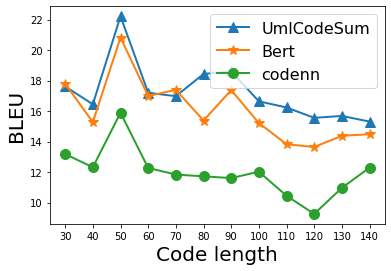

In [192]:
plot_three_bleu( scores_BLEU_Trans_var_codelen, scores_BLEU_Bert_var_codelen,scores_BLEU_codenn_var_codelen,"Code length","BLEU",10)

In [179]:
def plot_two_bleu(s1_data, s2_data,xlabel,ylabel,step):
    s1= {}
    s2 = {}

    for i in s1_data:
        if i %step ==0 and i<150:
            s1[i] = s1_data[i]
            s2[i] = s2_data[i]
    fontsize = 20
#     print(s1)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.plot(list(s1.keys()), list(s1.values()), marker='^', linewidth=2.0, markersize=15, label='UmlCodeSum')
    ax.plot(list(s2.keys()), list(s2.values()), marker='*', linewidth=2.0, markersize=15, label='Bert')
#     ax.plot(code_length, s3, marker='o', linewidth=2.0, markersize=15, label='Seq2Seq+Attn')
    ax.legend(fontsize='16') #, loc='upper center'
    ax.tick_params(labelsize=10)
    my_x_ticks =list(s1.keys())
    plt.xticks(my_x_ticks)
    plt.show()
#     fig.savefig(file)

Meteor  Rouge  Cider  BLEU

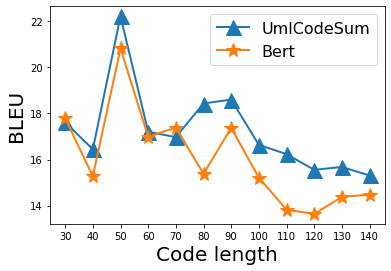

In [182]:
 plot_two_bleu( scores_BLEU_Trans_var_codelen, scores_BLEU_Bert_var_codelen,"Code length","BLEU",10)

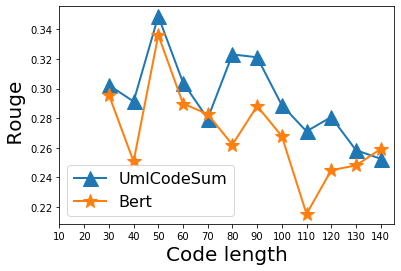

In [187]:
plot_two_bleu( scores_Rouge_Trans_var_codelen, scores_Rouge_Bert_var_codelen,"Code length"," Rouge",10)

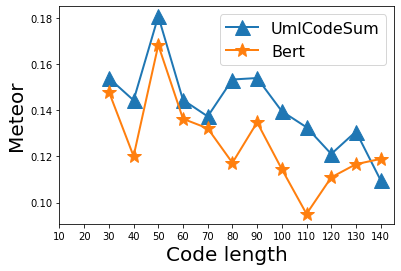

In [185]:
plot_two_bleu( scores_Meteor_Trans_var_codelen, scores_Meteor_Bert_var_codelen,"Code length","Meteor",10)

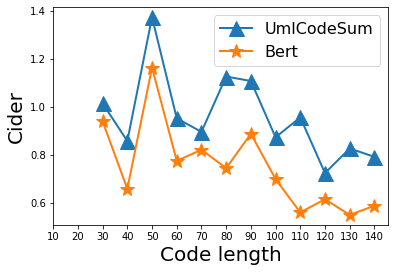

In [188]:
plot_two_bleu( scores_Cider_Trans_var_codelen, scores_Cider_Bert_var_codelen,"Code length","Cider",10)

In [ ]:
Meteor  Rouge  Cider  BLEU

In [ ]:
    
    step_size = 1
    scores_Meteor_Trans_var_codelen = {}
    scores_Rouge_Trans_var_codelen = {}
    scores_Cider_Trans_var_codelen = {}
    scores_BLEU_Trans_var_codelen = {}
    # Bas_code_len ={}
    # codeBerts_code_len ={}
    count_code_len = {}
    st = time.perf_counter()
    for code_len in range(10,250,step_size ):
        scores_Meteor_Trans_var_codelen[code_len] = []
        scores_Rouge_Trans_var_codelen[code_len] = []
        scores_Cider_Trans_var_codelen[code_len] = []
        predict= []
        target = []
        count_code_len[code_len] = 0
        for num in range(len( test_fids_Trans_in_paper)):
            fid =  test_fids_Trans_in_paper[num]
            if len(code_tokens["test"][fid]) == code_len:
                predict.append(preds_Trans_in_paper[ num])
                target.append(trgs_Trans_in_paper[ num])
                count_code_len[code_len] += 1
                scores_Meteor_Trans_var_codelen[code_len].append(scores_Meteor_Trans[num])
                scores_Rouge_Trans_var_codelen[code_len].append(scores_Rouge_Trans [num])
                scores_Cider_Trans_var_codelen[code_len] .append(scores_Cider_Trans[num])
        if len(predict) == 0:
            continue
        scores_BLEU_Trans_var_codelen[code_len ] = compute_smooth_bleu(target, predict)
    print("time cost: ",time.perf_counter() -st)
    for i in scores_Meteor_Trans_var_codelen:
        scores_Meteor_Trans_var_codelen[i] = np.mean(scores_Meteor_Trans_var_codelen[i])
        scores_Rouge_Trans_var_codelen[i] = np.mean(scores_Rouge_Trans_var_codelen[i])
        scores_Cider_Trans_var_codelen[i] = np.mean(scores_Cider_Trans_var_codelen[i])

In [132]:
step_size = 1
scores_Meteor_Trans_var_codelen = {}
scores_Rouge_Trans_var_codelen = {}
scores_Cider_Trans_var_codelen = {}
scores_BLEU_Trans_var_codelen = {}
# Bas_code_len ={}
# codeBerts_code_len ={}
count_code_len = {}
st = time.perf_counter()
for code_len in range(10,250,step_size ):
    scores_Meteor_Trans_var_codelen[code_len] = []
    scores_Rouge_Trans_var_codelen[code_len] = []
    scores_Cider_Trans_var_codelen[code_len] = []
    predict= []
    target = []
    count_code_len[code_len] = 0
    for num in range(len( test_fids_Trans_in_paper)):
        fid =  test_fids_Trans_in_paper[num]
        if len(code_tokens["test"][fid]) == code_len:
            predict.append(preds_Trans_in_paper[ num])
            target.append(trgs_Trans_in_paper[ num])
            count_code_len[code_len] += 1
            scores_Meteor_Trans_var_codelen[code_len].append(scores_Meteor_Trans[num])
            scores_Rouge_Trans_var_codelen[code_len].append(scores_Rouge_Trans [num])
            scores_Cider_Trans_var_codelen[code_len] .append(scores_Cider_Trans[num])
    if len(predict) == 0:
        continue
    scores_BLEU_Trans_var_codelen[code_len ] = compute_smooth_bleu(target, predict)
print("time cost: ",time.perf_counter() -st)


time cost:  4.396749243140221


In [140]:
for i in scores_Meteor_Trans_var_codelen:
    scores_Meteor_Trans_var_codelen[i] = np.mean(scores_Meteor_Trans_var_codelen[i])
    scores_Rouge_Trans_var_codelen[i] = np.mean(scores_Rouge_Trans_var_codelen[i])
    scores_Cider_Trans_var_codelen[i] = np.mean(scores_Cider_Trans_var_codelen[i])

/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yanlwang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


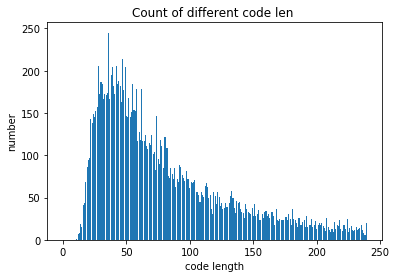

In [143]:
import matplotlib.pyplot as plt
plt.title("Count of different code len ")
plt.xlabel("code length")
plt.ylabel("number")
plt.bar(range(len(count_code_len)), count_code_len.values())
plt.show()

In [ ]:

plt.title("Count of different code len ")
plt.xlabel("code length")
plt.ylabel("number")
plt.bar(range(len(count_code_len)), count_code_len.values())
plt.show()

In [160]:
def plot_data(scores,step):
    scores_new= {}
    for i in scores:
#         print(i)
        if i %step ==0 and i<150:
            scores_new[i] = scores[i]
    plt.figure(figsize=(18,5))
    plt.plot(list(scores_new .keys())  ,list(scores_new .values()), label='scores_BLEU_Trans_var_codelen', linewidth=3, color='r', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.xlabel('diff code length ', fontsize=15)
    plt.ylabel('BLEU',fontsize=15)
    plt.legend()

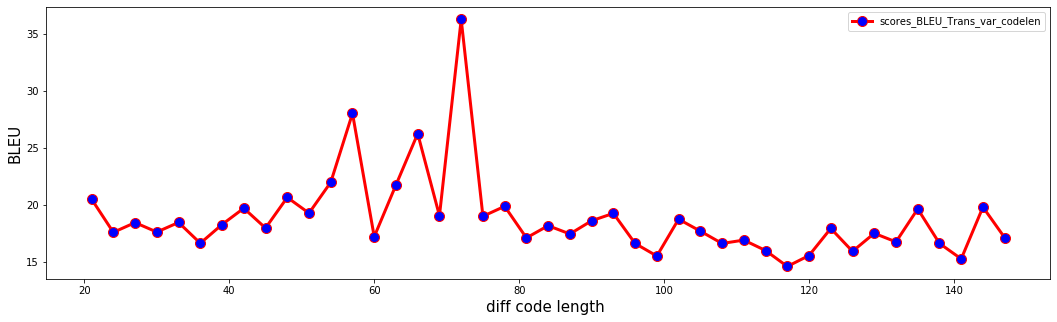

In [161]:
 plot_data(scores_BLEU_Trans_var_codelen,3)

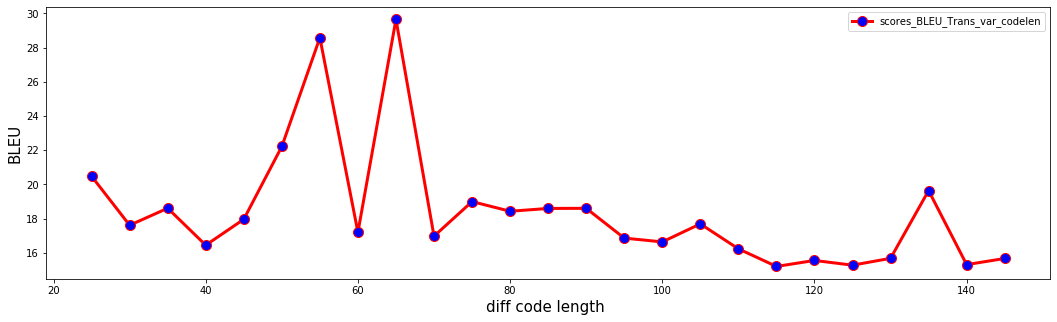

In [162]:
 plot_data(scores_BLEU_Trans_var_codelen,5)

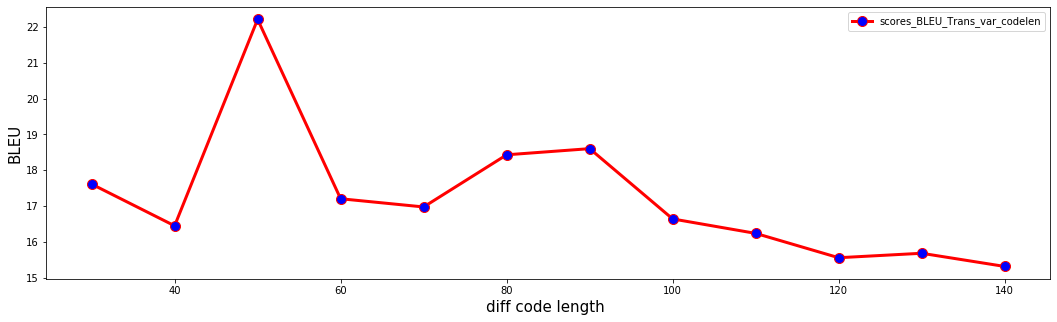

In [163]:
 plot_data(scores_BLEU_Trans_var_codelen,10)

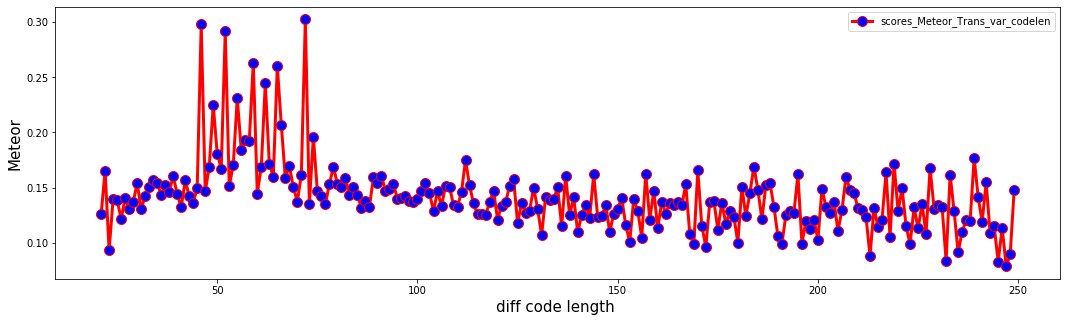

In [146]:
plt.figure(figsize=(18,5))
plt.plot(list(scores_Meteor_Trans_var_codelen .keys())  ,list(scores_Meteor_Trans_var_codelen .values()), label='scores_Meteor_Trans_var_codelen', linewidth=3, color='r', marker='o',
         markerfacecolor='blue', markersize=10)
plt.xlabel('diff code length ', fontsize=15)
plt.ylabel('Meteor',fontsize=15)
plt.legend()

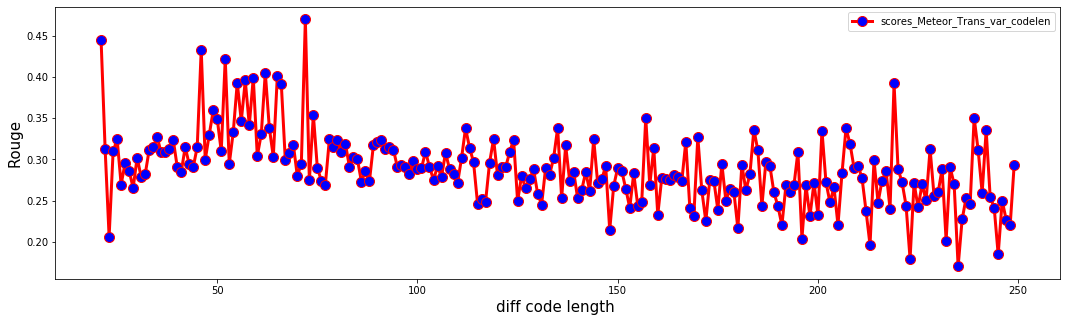

In [147]:
plt.figure(figsize=(18,5))
plt.plot(list(scores_Rouge_Trans_var_codelen .keys())  ,list(scores_Rouge_Trans_var_codelen .values()), label='scores_Meteor_Trans_var_codelen', linewidth=3, color='r', marker='o',
         markerfacecolor='blue', markersize=10)
plt.xlabel('diff code length ', fontsize=15)
plt.ylabel('Rouge',fontsize=15)
plt.legend()

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.gridspec as gridspec
import sys
import numpy as np
var_type = 'code'

def file2numpy(file):
    with open(file, 'r') as fi:
        return np.loadtxt(file)

def plot_f(code_length, s1, s2, s3, file, xlabel, ylabel):
    fontsize = 20
    fig = plt.figure()
#     fig.savefig('diff_code_le.eps',dpi=600,format='eps')
    ax = plt.subplot(111)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)

    ax.plot(code_length, s1, marker='^', linewidth=2.0, markersize=15, label='Hybrid2Seq+Attn+DRL')
    ax.plot(code_length, s2, marker='*', linewidth=2.0, markersize=15, label='Tree2Seq+Attn')
    ax.plot(code_length, s3, marker='o', linewidth=2.0, markersize=15, label='Seq2Seq+Attn')
    ax.legend(fontsize='16') #, loc='upper center'
    ax.tick_params(labelsize=20)

    # plt.show()
    fig.savefig(file)

if var_type == 'code':
    hybrid2seq_attn_a2c_var = file2numpy('hybrid2seq_attn_a2c_varcode.txt')
    seq2seq_attn_var = file2numpy('seq2seq_attn_varcode.txt')
    tree2seq_attn_var = file2numpy('hybrid2seq_attn_varcode.txt')
    code_length = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
elif var_type == 'comment':
    hybrid2seq_attn_a2c_var = file2numpy('hybrid2seq_attn_a2c_varcomment.txt')
    seq2seq_attn_var = file2numpy('seq2seq_attn_varcomment.txt')
    tree2seq_attn_var = file2numpy('hybrid2seq_attn_varcomment.txt')
    code_length = [0, 10, 20, 30, 40]

hybrid2seq_attn_a2c_var_b1 = hybrid2seq_attn_a2c_var[:,0].tolist()
seq2seq_attn_var_b1 = seq2seq_attn_var[:,0].tolist()
tree2seq_attn_var_b1 = tree2seq_attn_var[:,0].tolist()
# print(seq2seq_attn_varcode_b1)

hybrid2seq_attn_a2c_var_m = hybrid2seq_attn_a2c_var[:,4].tolist()
seq2seq_attn_var_m = seq2seq_attn_var[:,4].tolist()
tree2seq_attn_var_m = tree2seq_attn_var[:,4].tolist()
# print(seq2seq_attn_varcode_m)

hybrid2seq_attn_a2c_var_r = hybrid2seq_attn_a2c_var[:,5].tolist()
seq2seq_attn_var_r = seq2seq_attn_var[:,5].tolist()
tree2seq_attn_var_r = tree2seq_attn_var[:,5].tolist()

hybrid2seq_attn_a2c_var_c = hybrid2seq_attn_a2c_var[:,6].tolist()
seq2seq_attn_var_c = seq2seq_attn_var[:,6].tolist()
tree2seq_attn_var_c = tree2seq_attn_var[:,6].tolist()

if var_type == 'code':
    plot_f(code_length, hybrid2seq_attn_a2c_var_b1, tree2seq_attn_var_b1, seq2seq_attn_var_b1, './figure/varcode_bleu.pdf', 'Code length', 'BLEU')
    plot_f(code_length, hybrid2seq_attn_a2c_var_m, tree2seq_attn_var_m, seq2seq_attn_var_m, './figure/varcode_meteor.pdf', 'Code length', 'METEOR')
    plot_f(code_length, hybrid2seq_attn_a2c_var_r, tree2seq_attn_var_r, seq2seq_attn_var_r, './figure/varcode_rouge.pdf', 'Code length', 'ROUGE-L')
    plot_f(code_length, hybrid2seq_attn_a2c_var_c, tree2seq_attn_var_c, seq2seq_attn_var_c, './figure/varcode_cider.pdf', 'Code length', 'CIDER')
elif var_type == 'comment':
    plot_f(code_length, hybrid2seq_attn_a2c_var_b1, tree2seq_attn_var_b1, seq2seq_attn_var_b1, './figure/varcomment_bleu.pdf', 'Comment length', 'BLEU')
    plot_f(code_length, hybrid2seq_attn_a2c_var_m, tree2seq_attn_var_m, seq2seq_attn_var_m, './figure/varcomment_meteor.pdf', 'Comment length', 'METEOR')
    plot_f(code_length, hybrid2seq_attn_a2c_var_r, tree2seq_attn_var_r, seq2seq_attn_var_r, './figure/varcomment_rouge.pdf', 'Comment length', 'ROUGE-L')
    plot_f(code_length, hybrid2seq_attn_a2c_var_c, tree2seq_attn_var_c, seq2seq_attn_var_c, './figure/varcomment_cider.pdf', 'Comment length', 'CIDER')

## RQ3 package-wise

## UmlCodeSum

In [403]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/package_wise/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.modeltype = 'uml'
cf.class_only= False
cf.uml_path = "/datadrive/Data/csn/package_wise/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/package_wise/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")


cf.gnn_type= "HGCN"
cf.decoder_type = "ASTAttGRU_AttTwoChannelTrans"

root = "/datadrive/enshi/output_clen12/package-wise/output_package_wise_uml/"

model_file="39mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.5_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421060339.pt"

output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/package-wise/output_package_wise_uml/predict/ASTAttGRU_AttTwoChannelTrans.pkl
Meteor:  0.1599420117676997
ROUGe:  0.34064744714469725
Cider:  1.4440443124297035
---use stemming and replacing 'get' with 'return
empty_cnt 3
Meteor:  0.16511221410666604
ROUGe:  0.3547922621339624
Cider:  1.4959451367846481
time cost:  167.08112590759993


## BertAtt

In [404]:

cf.gnn_type= "GCN"
cf.decoder_type = "ASTAttGRU_BertAtt"

model_file="28mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.7_0.7_0.7-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh128_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200421105525.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/package-wise/output_package_wise_uml/predict/ASTAttGRU_BertAtt.pkl
Meteor:  0.14656220191810349
ROUGe:  0.32038456315869146
Cider:  1.2304079746576853
---use stemming and replacing 'get' with 'return
empty_cnt 2
Meteor:  0.1510748765376559
ROUGe:  0.33313960330503156
Cider:  1.2717319501697464
time cost:  110.76914841122925


## ast-attn-gru

In [405]:

cf.modeltype = 'ast-att-gru'

root = "/datadrive/enshi/output_clen12/package-wise/output_package_wise_h_deepcom_ast_att_gru/"
model_file="12mtast-att-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421100703.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/package-wise/output_package_wise_h_deepcom_ast_att_gru/predict/ast-att-gru.pkl
Meteor:  0.1425934573089446
ROUGe:  0.31055267790043173
Cider:  1.2100317493055033
---use stemming and replacing 'get' with 'return
empty_cnt 8
Meteor:  0.14740228315585652
ROUGe:  0.3240404980003967
Cider:  1.2522669778975362
time cost:  133.8215093780309


## att-gru

In [406]:
cf.modeltype = 'att-gru'

root = "/datadrive/enshi/output_clen12/package-wise/output_package_wise_h_deepcom_ast_att_gru/"
model_file="14mtatt-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421143809.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/package-wise/output_package_wise_h_deepcom_ast_att_gru/predict/att-gru.pkl
Meteor:  0.14080116565502945
ROUGe:  0.3088808659658387
Cider:  1.1858466863701493
---use stemming and replacing 'get' with 'return
empty_cnt 2
Meteor:  0.14547971113033092
ROUGe:  0.3217285828314576
Cider:  1.22394478024524
time cost:  79.7553990483284


## h-deepcom

In [408]:
cf.modeltype = 'h-deepcom'
root = "/datadrive/enshi/output_clen12/package-wise/output_package_wise_h_deepcom_ast_att_gru/"
# model_file="14mtatt-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421143809.pt"
model_file="27mth-deepcom_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421055944.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/package-wise/output_package_wise_h_deepcom_ast_att_gru/predict/h-deepcom.pkl
Meteor:  0.11122380673613255
ROUGe:  0.25710966239241423
Cider:  0.7612467377149021
---use stemming and replacing 'get' with 'return
empty_cnt 0
Meteor:  0.11557345714984368
ROUGe:  0.2688903374344575
Cider:  0.7835943537402436
time cost:  250.52697123587132


## codenn

In [ ]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/package_wise/summary/cfp1_csi1_cfd0_clc1.pkl"

cf.class_only= False
cf.uml_path = "/datadrive/Data/csn/package_wise/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/package_wise/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")


cf.modeltype = 'codenn'
root = "/datadrive/enshi/output_clen12/package-wise/output_package_wise_codenn/"
# model_file="14mtatt-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421143809.pt"
# model_file="27mth-deepcom_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421055944.pt"
model_file="38mtcodenn_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.7_0.7_0.7-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh128_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200422042250.pt"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/package-wise/output_package_wise_codenn/predict/codenn.pkl
Meteor:  0.08934019867349309
ROUGe:  0.2207209631916356
Cider:  0.5844568054160519
---use stemming and replacing 'get' with 'return
empty_cnt 0


## RQ3 method-wise

## CodeUml

In [68]:
cf.docstring_tokens_split_path = "/datadrive/Data/csn/method_wise/summary/cfp1_csi1_cfd0_clc1.pkl"
cf.modeltype = 'uml'
cf.class_only= False
cf.uml_path = "/datadrive/Data/csn/method_wise/uml/uml_dataset.pt"
data_path = "/datadrive/Data/csn/method_wise/dataset/"
cf.in_path = os.path.join(data_path,"dlen100_clen12_slen435_dvoc10000_cvoc10000_svoc10000_dataset.pkl")


cf.gnn_type= "HGCN"
cf.decoder_type = "ASTAttGRU_AttTwoChannelTrans"

root = "/datadrive/enshi/output_clen12/method_wise/output_method_wise_AttTwoChannel/"

# model_file="39mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.5_gss0.0_gnf513_gnh256_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421060339.pt"
model_file="umlASTAttGRU_AttTwoChannel2020-05-02-21_22_47model.pth"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/method_wise/output_method_wise_AttTwoChannel/predict/ASTAttGRU_AttTwoChannelTrans.pkl
Meteor:  0.17797660869068138
ROUGe:  0.37430302866334586
Cider:  1.7414693791794658
---use stemming and replacing 'get' with 'return
empty_cnt 2
Meteor:  0.18329326913289673
ROUGe:  0.38889643511781496
Cider:  1.796703993458509
time cost:  244.58093723841012


## bert attn

In [74]:

cf.gnn_type= "GCN"
cf.decoder_type = "ASTAttGRU_BertAtt"

# model_file="28mtuml_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyGCN_gdp0.7_0.7_0.7-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh128_256-aggMean-cloFalse_dtyASTAttGRU_BertAtt20200421105525.pt"
root = "/datadrive/enshi/output_clen12/method_wise/output_method_wise_BertAtt/"

model_file="umlASTAttGRU_BertAtt2020-05-02-13_26_53model.pth"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result_uml( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/method_wise/output_method_wise_BertAtt/predict/ASTAttGRU_BertAtt.pkl
Meteor:  0.1743319052884003
ROUGe:  0.3652345229565785
Cider:  1.6941973265466068
---use stemming and replacing 'get' with 'return
empty_cnt 5
Meteor:  0.17942653320751611
ROUGe:  0.3790249706754567
Cider:  1.7434025606750496
time cost:  113.00381587259471


## ast-attn-gru

In [71]:
cf.modeltype = 'ast-att-gru'

root = "/datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/"
# model_file="12mtast-att-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421100703.pt"
model_file="ast-att-gruASTAttGRU_AttTwoChannelTransmodel.pth"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/predict/ast-att-gru.pkl
Meteor:  0.1583266530206802
ROUGe:  0.3319438039016023
Cider:  1.5316491041322096
---use stemming and replacing 'get' with 'return
empty_cnt 3
Meteor:  0.16249298551767755
ROUGe:  0.34303590965089725
Cider:  1.557808984664919
time cost:  90.30638176202774


## attn-gru

In [70]:
cf.modeltype = 'att-gru'

root = "/datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/"
# model_file="12mtast-att-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421100703.pt"
model_file="att-gruASTAttGRU_AttTwoChannelTransmodel.pth"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/predict/att-gru.pkl
Meteor:  0.1582577698086221
ROUGe:  0.3324607930735908
Cider:  1.4988373664783379
---use stemming and replacing 'get' with 'return
empty_cnt 1
Meteor:  0.1630060389792544
ROUGe:  0.3456019531786606
Cider:  1.5339062239379684
time cost:  61.83122702687979


## h-deepcom

In [72]:
cf.modeltype = 'h-deepcom'

root = "/datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/"
# model_file="12mtast-att-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421100703.pt"
model_file="h-deepcomASTAttGRU_AttTwoChannelTransmodel.pth"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/predict/h-deepcom.pkl
Meteor:  0.12900271001692065
ROUGe:  0.2858448608837603
Cider:  0.9470610079805756
---use stemming and replacing 'get' with 'return
empty_cnt 2
Meteor:  0.13264085634951805
ROUGe:  0.296521966458127
Cider:  0.9626650000345667
time cost:  238.0537157896906


## codenn

In [73]:
cf.modeltype = 'codenn'

root = "/datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/"
# model_file="12mtast-att-gru_bs256_ddim128_cdim128_sdim128_hdim256_lr0.001_gtyHGCN_gdp0.6_0.6_0.6-gfn0-gpp0_gfc1_wd0.3_gss0.0_gnf513_gnh512_256-aggMean-cloFalse_dtyASTAttGRU_AttTwoChannelTrans20200421100703.pt"
model_file="codennASTAttGRU_AttTwoChannelTransmodel.pth"
output_prediction_file = model_file + '.pred'
model_path = os.path.join(root,"model",model_file )
output_dir = os.path.join(root,"predict") 
make_directory(output_dir)
# output_path = os.path.join(root,"predict",output_prediction_file )
st = time.perf_counter()
_,_,_ = predict_result( model_path,output_dir,output_prediction_file)
print("time cost: ",time.perf_counter() -st)

INFO:CodeSummary:[Setting] device: cpu
INFO:CodeSummary:Cannot find GPU id 0! Use CPU.
INFO:CodeSummary:[Setting] device: cpu


save dataset in /datadrive/enshi/output_clen12/method_wise/output_method_wise_codenn/predict/codenn.pkl
Meteor:  0.11544400405715473
ROUGe:  0.26331025366787614
Cider:  0.807816088725833
---use stemming and replacing 'get' with 'return
empty_cnt 0
Meteor:  0.11892117434160815
ROUGe:  0.2727678235260504
Cider:  0.824415812156069
time cost:  218.73138472624123
